In [12]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [13]:
# Use the GPU
if torch.backends.mps.is_available():
    print("MPS device is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA device is available.")
    device = torch.device("cuda")
else:
    print("No GPU acceleration available.")
    device = torch.device("cpu")

# Fix the seed to have deterministic behaviour
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

SEED = 1337
fix_random(SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATASET_PATH = "dataset_train/dataset.csv"
dataset = pd.read_csv(DATASET_PATH, delimiter=",")

print(f"Shape of the dataset: {dataset.shape}")
duplicates = dataset[dataset.duplicated()]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

MPS device is available.
Shape of the dataset: (148301, 145)
Number of duplicates in the dataset: 0


In [14]:
print(dataset["grade"].isna().sum())

0


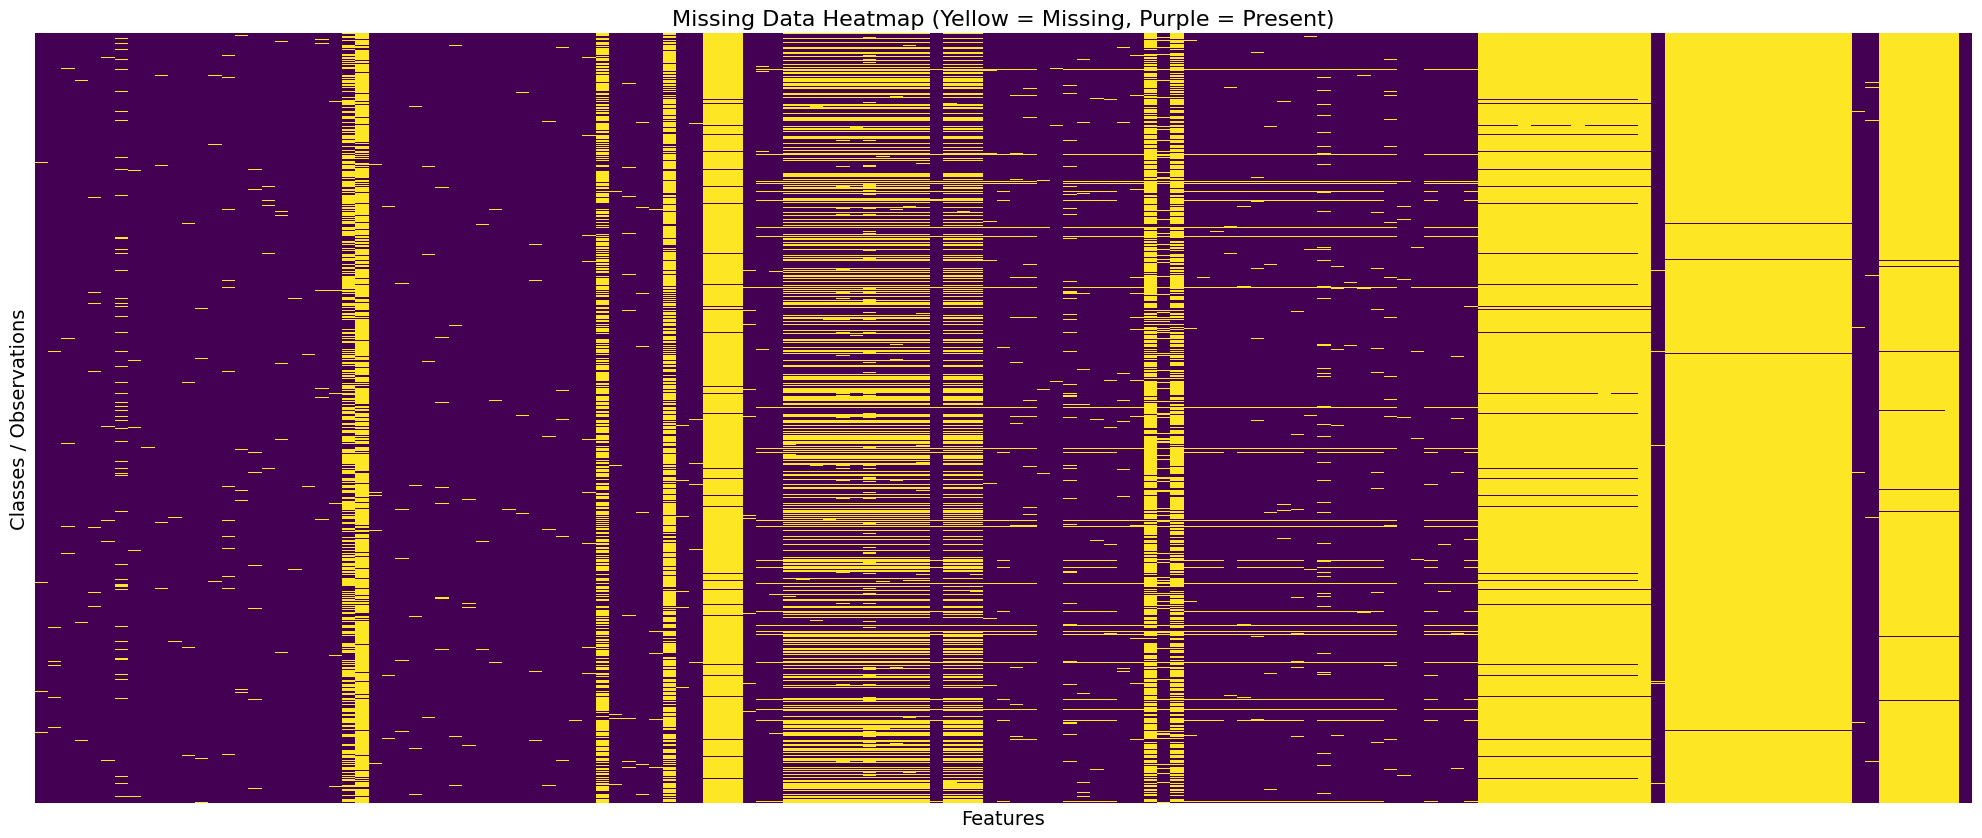

In [15]:
plt.figure(figsize=(25, 10))

ax = sns.heatmap(
    dataset.isnull(), 
    cbar=False, 
    yticklabels=False, 
    cmap='viridis',
    xticklabels=False
)

# Add the axis labels
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Classes / Observations', fontsize=14)

# Add the title
plt.title('Missing Data Heatmap (Yellow = Missing, Purple = Present)', fontsize=16)

plt.show()

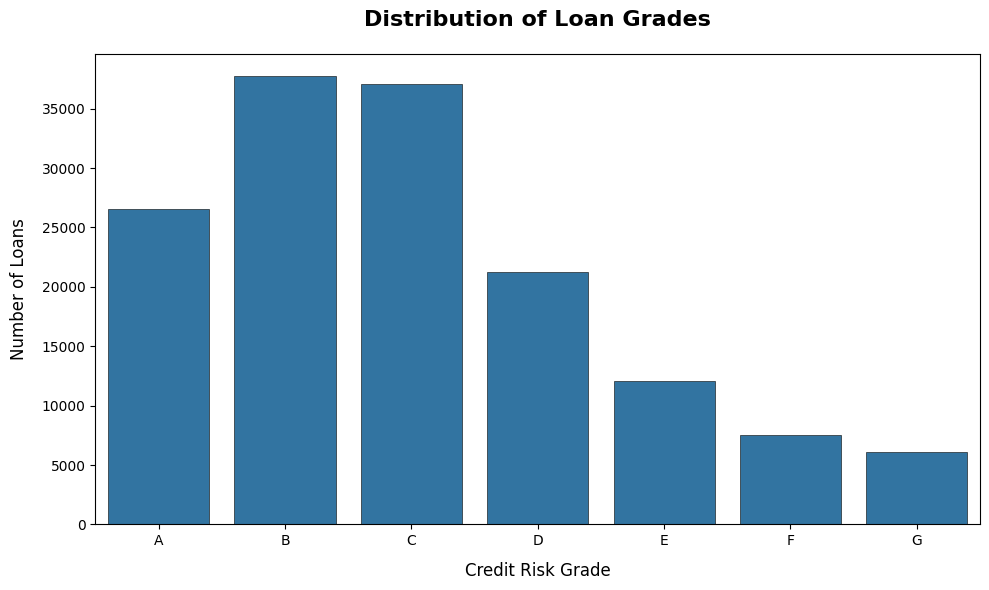

In [16]:
plt.figure(figsize=(10, 6))
grade_types = sorted(dataset['grade'].unique())
ax = sns.countplot(
    data=dataset, 
    x='grade', 
    order=grade_types, 
    edgecolor='black',
    linewidth=0.4
)

plt.title('Distribution of Loan Grades', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Credit Risk Grade', fontsize=12, labelpad=10)
plt.ylabel('Number of Loans', fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

## Handling NaNs
We drop columns with more than 20% of NaNs. We go from 145 to 89 features

original_projected_additional_accrued_interest       99.564399
hardship_loan_status_label                           99.432910
hardship_type_label                                  99.431561
hardship_end_date                                    99.431561
hardship_duration_days                               99.430887
hardship_last_payment_amount_total                   99.430887
hardship_days_past_due                               99.430887
hardship_reason_label                                99.430213
hardship_start_date                                  99.429539
hardship_payment_plan_start_date                     99.429539
hardship_deferral_term_months                        99.428864
hardship_status_label                                99.428190
hardship_amount_total                                99.428190
hardship_payoff_balance                              99.427516
secondary_applicant_months_since_last_major_derog    98.374927
settlement_term_months                               98

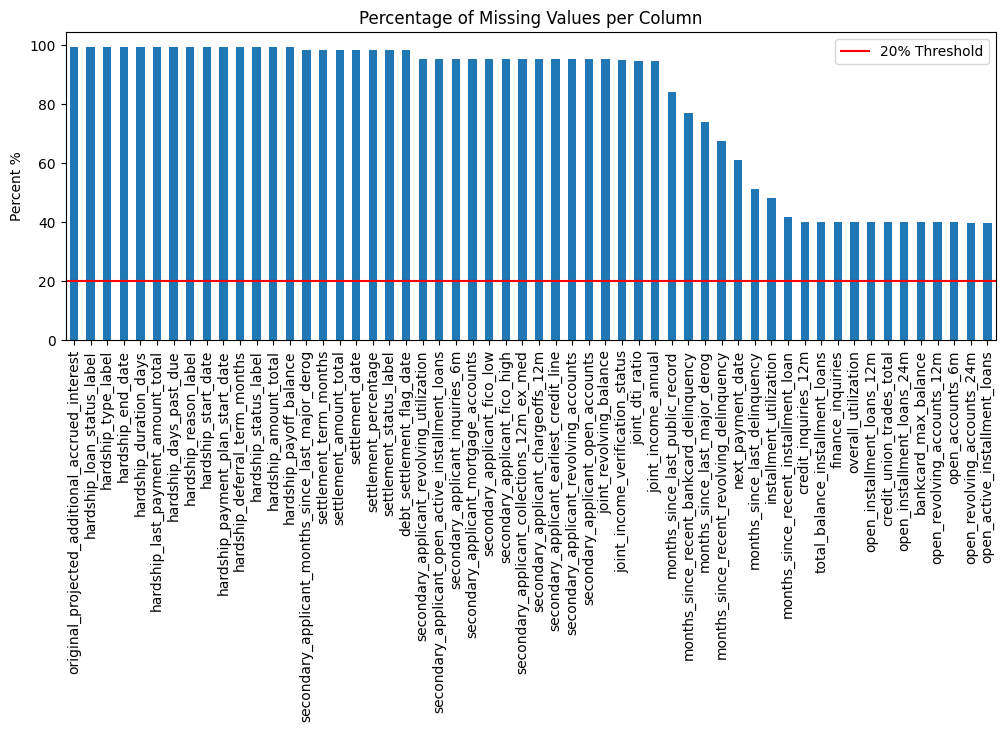

Shape before dropping columns: (148301, 145)
Shape after dropping columns: (148301, 88)


In [17]:
COLUMNS_TO_DROP_PERCENT = 20

# Show the percentage of missing values
missing_percentages = dataset.isna().mean() * 100
cols_to_drop = missing_percentages[missing_percentages > COLUMNS_TO_DROP_PERCENT]
print(cols_to_drop.sort_values(ascending=False))

plt.figure(figsize=(12, 4))
cols_to_drop.sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percent %')
plt.axhline(y=COLUMNS_TO_DROP_PERCENT, color='r', linestyle='-', label=f'{COLUMNS_TO_DROP_PERCENT}% Threshold')
plt.legend()
plt.show()

# drop columns with more than 20% of NaNs. We go from 145 to 89 features
print(f"Shape before dropping columns: {dataset.shape}")
dataset.drop(columns=cols_to_drop.index, inplace=True)
# Drop also loan_title since it's redundant with loan_purpose_category
dataset.drop(columns="loan_title", inplace=True)
print(f"Shape after dropping columns: {dataset.shape}")

In [18]:
# User setting: How many top/bottom features to display?
N = 5  # <--- Change this number to show more or fewer columns
dataset["grade"] = dataset["grade"].map({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})

# ---------------------------------------------------------
# Step 1: Calculate and Filter Correlations
# ---------------------------------------------------------

# Calculate correlation of all columns with 'grade'
# We use numeric_only=True to handle non-numeric columns safely
target_corr = dataset.corr(numeric_only=True)['grade'].drop('grade').sort_values()

# Select the Top N negative (head) and Top N positive (tail)
top_negative = target_corr.head(N)
top_positive = target_corr.tail(N)

# Combine them into one list for plotting
# We use pd.concat to merge the two series
filtered_corr = pd.concat([top_positive, top_negative]).sort_values(ascending=False)

print(f"Showing top {N} positive and bottom {N} negative correlations.")

Showing top 5 positive and bottom 5 negative correlations.


## Categorical data conversion and dataset splitting

In [ ]:
numerical_cols = dataset.select_dtypes(include=['number']).columns

print("Before converting categorical data")
categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
# print(f"Categorical columns:\n{categorical_cols.sort_values()}")
print("Categorical columns")
for col in categorical_cols:
    print(col)
    print(f"Unique features: {len(dataset[col].unique())}")
    print(dataset[col].unique())
    print("-"*50)

# 
# 

Before converting categorical data
Categorical columns
loan_contract_term_months
Unique features: 3
[' 36 months' ' 60 months' nan]
--------------------------------------------------
borrower_profile_employment_length
Unique features: 12
['10+ years' '2 years' '8 years' nan '1 year' '3 years' '6 years'
 '7 years' '9 years' '< 1 year' '5 years' '4 years']
--------------------------------------------------
borrower_housing_ownership_status
Unique features: 7
['rent' 'mortgage' 'own' nan 'any' 'other' 'none']
--------------------------------------------------
borrower_income_verification_status
Unique features: 4
['source verified' 'not verified' 'verified' nan]
--------------------------------------------------
loan_issue_date
Unique features: 139
['jan-2017' 'mar-2015' 'may-2017' 'jun-2013' 'sep-2012' 'may-2016'
 'aug-2017' 'dec-2015' 'nov-2015' 'apr-2013' 'jul-2016' 'feb-2016'
 'oct-2017' 'jun-2017' 'may-2015' 'oct-2018' 'feb-2017' 'jul-2018'
 'sep-2016' 'sep-2011' 'oct-2015' 'jun-2015

### Stateless categorical data conversion

In [21]:
# Stateless transformations (can be done on train and test set independently)
dataset["grade"] = dataset["grade"].map({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})

def extract_int_value_from_column(column_name):
    dataset[column_name] = dataset[column_name].str.extract(r"(\d+)").astype("Int64")

extract_int_value_from_column("loan_contract_term_months")
extract_int_value_from_column("borrower_profile_employment_length")

# DROP FOR TREES, USE FOR DEEP ENTWORKS
# extract_int_value_from_column("borrower_address_zip")
dataset.drop(columns="borrower_address_zip", inplace=True)
dataset.drop(columns="borrower_address_state", inplace=True)

def convert_mm_yyyy_to_year_sine_cosine(column_name):
    # Convert mm-yyyy to the year and month encoded in sine/cosine representation so that dec 1999 and jan 2000 are close
    dataset[column_name] = pd.to_datetime(dataset[column_name], format='%b-%Y')
    date_col = dataset[column_name].dt # avoid creating temporary object
    dataset[f"{column_name}_year"] = date_col.year
    angle = 2 * np.pi * date_col.month / 12
    dataset[f"{column_name}_month_sin"] = np.sin(angle)
    dataset[f"{column_name}_month_cos"] = np.cos(angle)
    dataset.drop(columns=[column_name], inplace=True)

convert_mm_yyyy_to_year_sine_cosine("loan_issue_date")
convert_mm_yyyy_to_year_sine_cosine("credit_history_earliest_line")
convert_mm_yyyy_to_year_sine_cosine("last_payment_date")
convert_mm_yyyy_to_year_sine_cosine("last_credit_pull_date")

In [22]:
# # This will plot ALL features but cluster the correlated ones together
# sns.clustermap(dataset.corr(numeric_only=True), cmap='RdBu', vmin=-1, vmax=1, center=0)
# plt.show()

In [23]:
# # Boxplot is great for seeing medians and spread
# sns.boxplot(data=dataset, x='grade', y=top_negative.index[0])
# plt.title(f'Distribution of {top_negative.index[0]} per Grade Level')
# plt.show()

In [24]:
for i in range(N):
    print(top_negative.index[i])
    print(dataset[top_negative.index[i]].mean())
    print(dataset[top_negative.index[i]].std())

loan_contract_interest_rate
14.338888651728013
6.029603453299856
total_received_interest
2816.716956173679
3252.0652480880603
bankcard_utilization
58.98572203997984
28.76007823945454
bankcard_util_gt_75_ratio
43.83965404454655
36.49985720997409
revolving_utilization
51.2628995509547
24.910337022297657


### Splitting the dataset

In [25]:
categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns:\n{categorical_cols.sort_values()}")

Categorical columns:
Index(['application_type_label', 'borrower_housing_ownership_status',
       'borrower_income_verification_status', 'debt_settlement_flag_indicator',
       'disbursement_method_type', 'hardship_flag_indicator',
       'listing_initial_status', 'loan_payment_plan_flag',
       'loan_purpose_category', 'loan_status_current_code'],
      dtype='object')


In [26]:
tmp = ['application_type_label', 'borrower_address_state',
       'borrower_housing_ownership_status',
       'borrower_income_verification_status', 'debt_settlement_flag_indicator',
       'disbursement_method_type', 'hardship_flag_indicator',
       'joint_income_verification_status', 'listing_initial_status',
       'loan_payment_plan_flag', 'loan_purpose_category',
       'loan_status_current_code', 'next_payment_date']
for el in tmp:
    print(el)
    print(dataset[el].unique())
    print("-"*20)

one_hot_encoding_cols = ["application_type_label", "borrower_housing_ownership_status",
                         "borrower_income_verification_status", "joint_income_verification_status",
                         "loan_purpose_category", "loan_status_current_code"]
binary_cols = ["debt_settlement_flag_indicator", "disbursement_method_type", "hardship_flag_indicator"
               "listing_initial_status", "loan_payment_plan_flag"]
date = ["next_payment_date"]
# borrower_address_state remove because it's redundant with zip code
# borrower_housing_ownership_status one 

application_type_label
['individual' 'joint app' nan]
--------------------
borrower_address_state


KeyError: 'borrower_address_state'

In [ ]:
X = dataset.drop(columns=["grade"])
y = dataset["grade"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

print("Training set")
print(X_train.shape)
print(y_train.shape)

print("Validation set")
print(X_val.shape)
print(y_val.shape)

### Stateful categorical data conversion

In [ ]:
# Stateful transformations (with statistics calculated on training set and applied on both sets)

# We transform the binary categorical cols with 1 and 0. We use 1 for the least frequent data
# because it carries more signal
binary_categorical_cols = ["loan_payment_plan_flag", "listing_initial_status", "application_type_label",
               "hardship_flag_indicator", "disbursement_method_type", "debt_settlement_flag_indicator"]
binary_categorical_cols_feature_map = {}

# FIT: Calculate mode only on X_train
# TRANSFORM: Apply to X_train and x_val using the mode of X_train
for col in binary_categorical_cols:
    col_mode = X_train[col].mode()[0]
    binary_categorical_cols_feature_map[col] = col_mode
    X_train[col] = (X_train[col] != col_mode).astype("Int64")
    X_val[col] = (X_val[col] != col_mode).astype("Int64")


one_hot_encoding_cols = ["borrower_housing_ownership_status", "borrower_income_verification_status",
                       "loan_status_current_code", "loan_purpose_category", "borrower_address_state"]

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[one_hot_encoding_cols])
one_hot_encoding_feature_names = encoder.get_feature_names_out(one_hot_encoding_cols)

# Apply one-hot encoding to the training set
X_train_encoded = pd.DataFrame(encoder.transform(X_train[one_hot_encoding_cols]), columns=one_hot_encoding_feature_names, index=X_train.index)
X_train = pd.concat([X_train.drop(columns=one_hot_encoding_cols), X_train_encoded], axis=1)

# Apply one-hot encoding to the test set
X_val_encoded = pd.DataFrame(encoder.transform(X_val[one_hot_encoding_cols]), columns=one_hot_encoding_feature_names, index=X_val.index)
X_val = pd.concat([X_val.drop(columns=one_hot_encoding_cols), X_val_encoded], axis=1)

In [ ]:
# print(X_train["borrower_address_zip"].unique())

In [ ]:
print("After converting categorical data")
print(f"Train Shape: {X_train.shape}")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns:\n{categorical_cols}")
print(f"Test Shape:  {X_val.shape}")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns:\n{categorical_cols}")

In [ ]:
# Assume X_train is your processed numeric dataframe
# Calculate the correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
# (Because the matrix is symmetrical, we only need to check one half)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop)} columns that are redundant: {to_drop}")

# Drop them
X_train_reduced = X_train.drop(columns=to_drop)
X_val_reduced = X_val.drop(columns=to_drop)

In [ ]:
print("Before dropping")
print(X_train.shape)
print(X_val.shape)

X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]

X_val.dropna(inplace=True)
y_val = y_val.loc[X_val.index]

print("After dropping")
print(X_train.shape)
print(X_val.shape)

# ---------------------------

## Handling the remaining columns

We don't know if the column `months_since_recent_inquiry` with a NaN means that the person never had an inquiry or the value is missing for another reason.
The strategy is:

- for linear models: we fill in mean/median based on the distribution
- for tree models: we use an extreme number (np.max) to introduce a clear separation
- for deep learning models: create a column `never_had_inquiry` to set to 1 where we have a NaN.

In [ ]:
print(X_train.shape)
list(dataset)